# Directional EDA and modelling

In [29]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.io as pio
from plot_tools import px_density, theme
pio.renderers.default = 'png'
pd.options.plotting.backend = 'plotly'
px.defaults.template = 'plotly_dark'
px.defaults.height = 650
px.defaults.width = 1000

plasma = px.colors.sequential.Plasma
plasma_cyc1 = plasma[1:] + plasma[::-1][1:-1]
plasma_cyc2 = plasma[1:-1] + plasma[::-1][2:-1]

In [11]:
def show(plot, h=650, w=1000):
    plot = theme(plot)
    plot.show(height=h, width=w)

In [12]:
df = pd.read_csv('../ocean-waves-full.csv', parse_dates=['DateTime'])
df.rename(columns={'CottRadiansRotated': 'CottRad', 'RottRadiansRotated': 'RottRad'}, inplace=True)

In [13]:
SEASONS = ['Summer','Autumn','Winter','Spring']

def month_to_season(month, name=False):
    season_num = (month%12 + 3) // 3
    if name:
        return SEASONS[season_num - 1]
    else:
        return season_num
    
df['Season'] = df['Month'].apply(month_to_season, name=True).astype('category')
df['Season'].cat.set_categories(
    SEASONS, ordered=True, inplace=True
)

In [14]:
dt_range = pd.date_range(min(df['DateTime']), max(df['DateTime']), freq='30min')
time_df = df.set_index('DateTime').reindex(index=dt_range)

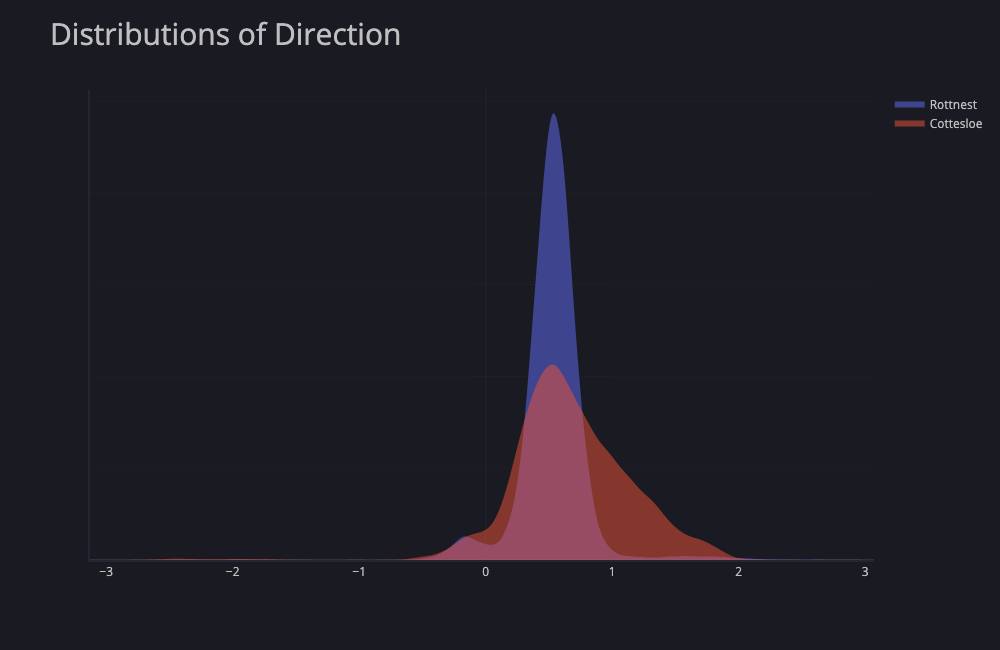

In [17]:
p = px_density(df, ['RottRad','CottRad'], custom_labs=['Rottnest','Cottesloe'],
               title='Distributions of Direction', lines=False, show_y=False)
p = theme(p).update_yaxes(showline=False)
show(p)

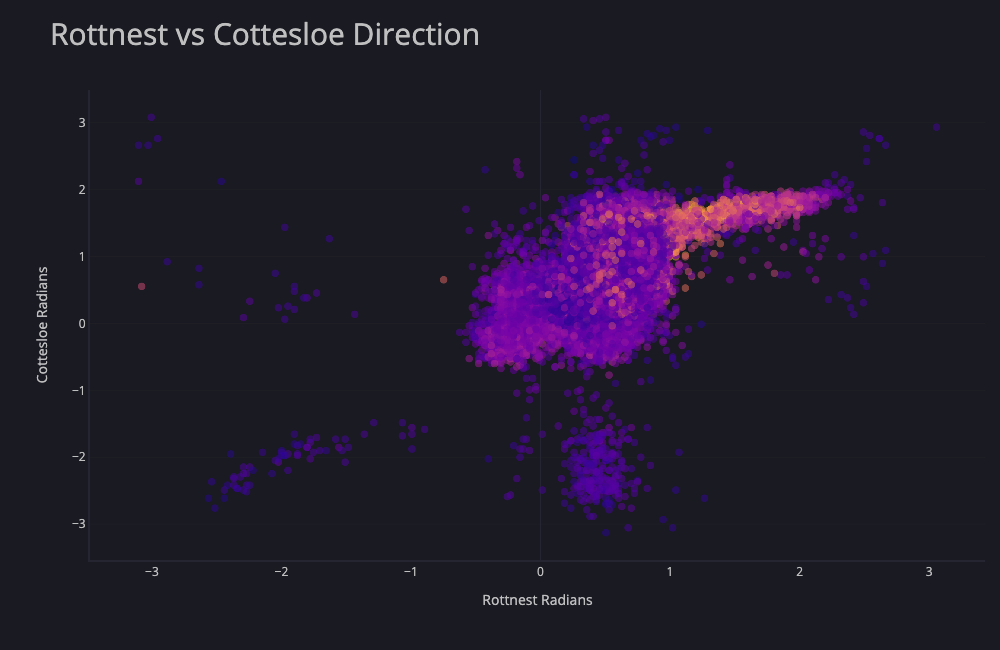

In [18]:
p2 = px.scatter(df, 'RottRad', 'CottRad', color='CottHeight', opacity=0.5,
                title='Rottnest vs Cottesloe Direction',
                labels={'CottRad': 'Cottesloe Radians', 'RottRad': 'Rottnest Radians'})
p2 = theme(p2).update_yaxes(zeroline=False).update_layout(coloraxis_showscale=False)
show(p2)

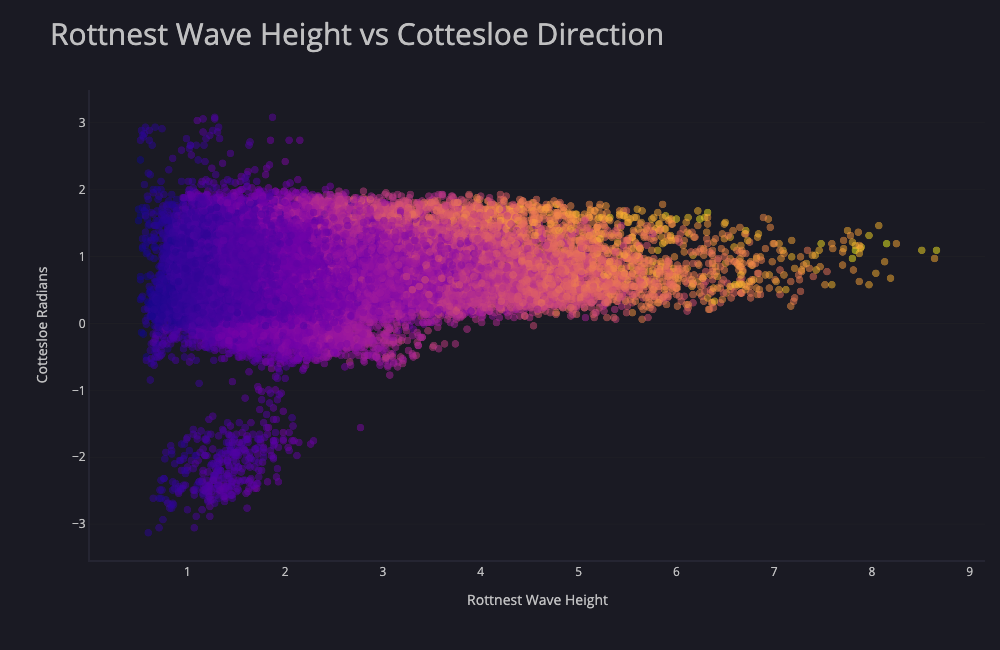

In [19]:
p3 = px.scatter(df, 'RottHeight', 'CottRad', color='CottHeight', opacity=0.5,
                title='Rottnest Wave Height vs Cottesloe Direction',
                labels={'CottRad': 'Cottesloe Radians', 'RottHeight': 'Rottnest Wave Height'})
p3 = theme(p3).update_yaxes(zeroline=False).update_layout(coloraxis_showscale=False)
show(p3)

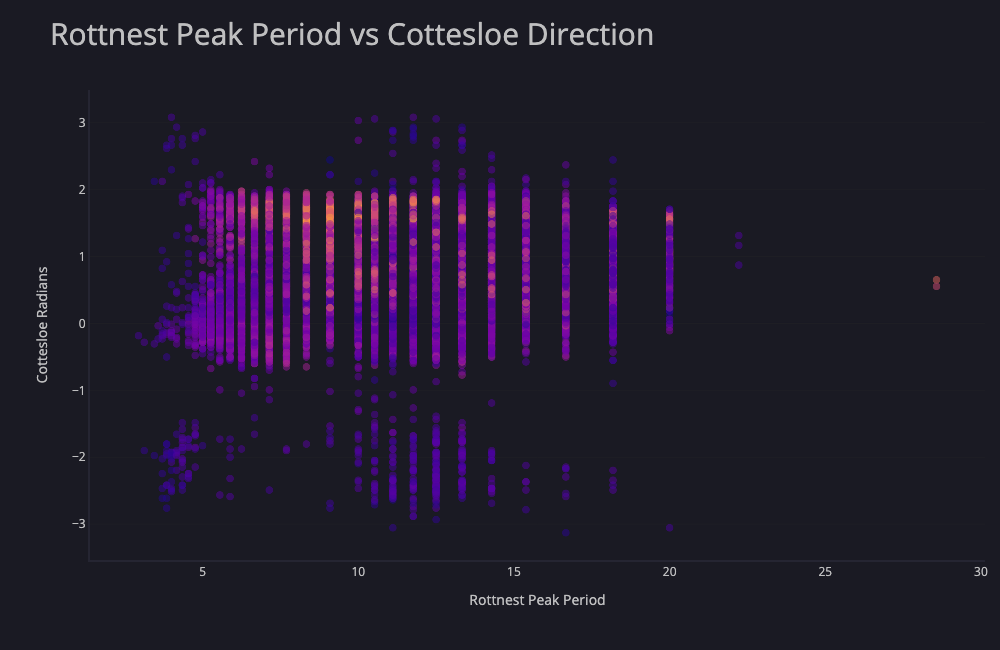

In [20]:
p4 = px.scatter(df, 'RottPeakPeriod', 'CottRad', color='CottHeight', opacity=0.5,
                title='Rottnest Peak Period vs Cottesloe Direction',
                labels={'CottRad': 'Cottesloe Radians', 'RottPeakPeriod': 'Rottnest Peak Period'})
p4 = theme(p4).update_yaxes(zeroline=False).update_layout(coloraxis_showscale=False)
show(p4)

In [21]:
mnth_med = df.groupby('Month')['CottRad'].median()

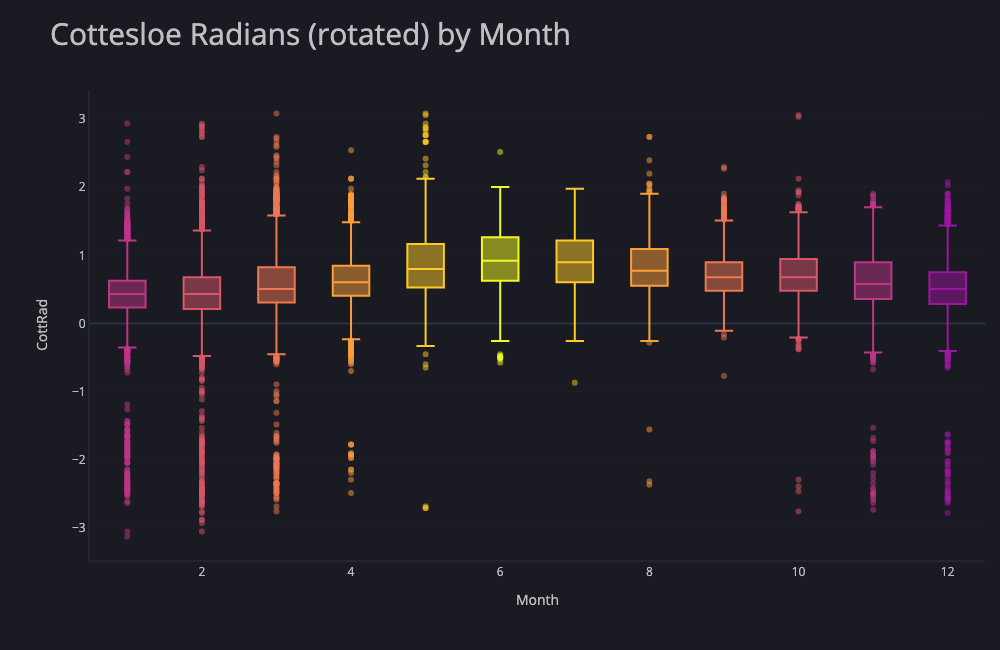

In [23]:
p8 = px.box(df, 'Month', 'CottRad', color='Month', color_discrete_sequence=plasma_cyc1[3:16],
            category_orders=dict(Month=list(range(1,13))), title='Cottesloe Radians (rotated) by Month')\
                .update_layout(showlegend=False).update_traces(marker_opacity=0.5)
show(theme(p8))

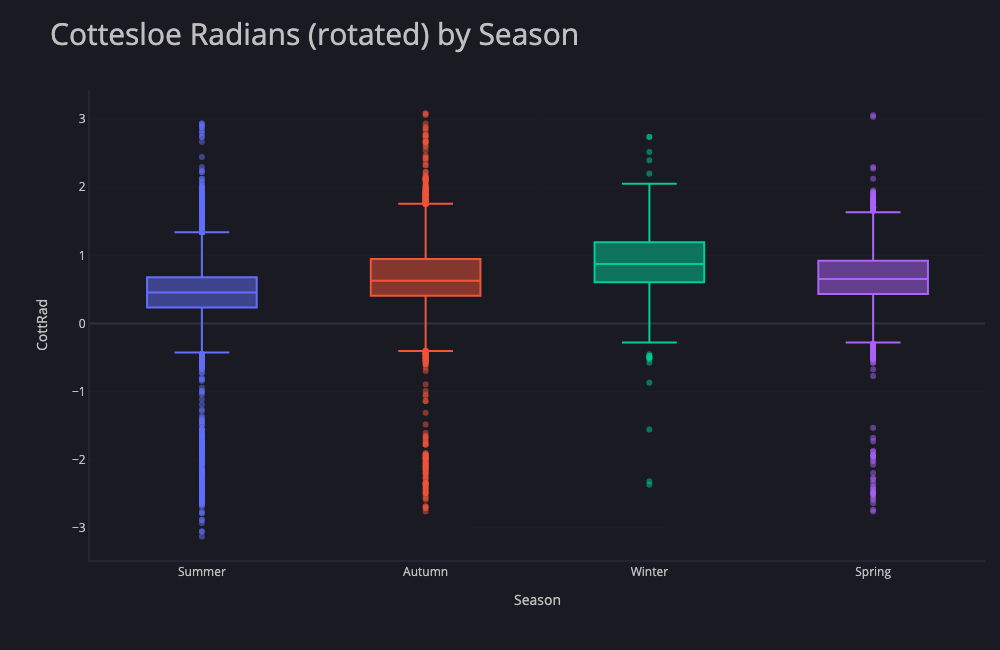

In [24]:
p9 = px.box(df, 'Season', 'CottRad', color='Season', title='Cottesloe Radians (rotated) by Season')\
                .update_layout(showlegend=False).update_traces(marker_opacity=0.5)
show(theme(p9))

In [25]:
tmp = []
for season in SEASONS:
    tmp.append(df.query('Season == @season')['CottRad'])
ssn_df = pd.concat(tmp, axis=1)
ssn_df.columns = SEASONS

In [26]:
kde = ff.create_distplot(
    [df.query('Season == @season')['CottRad'] for season in SEASONS],
    group_labels=SEASONS, show_hist=False, show_rug=False)

p10 = px.area(title='Cottesloe Direction by Season')
for i, var in enumerate(SEASONS):
    p10.add_scatter(mode='lines', x=kde.data[i]['x'], y=kde.data[i]['y'],
                    name=SEASONS[i], fill='tozeroy')  #,line_color=plasma_cyc[1::4][i])

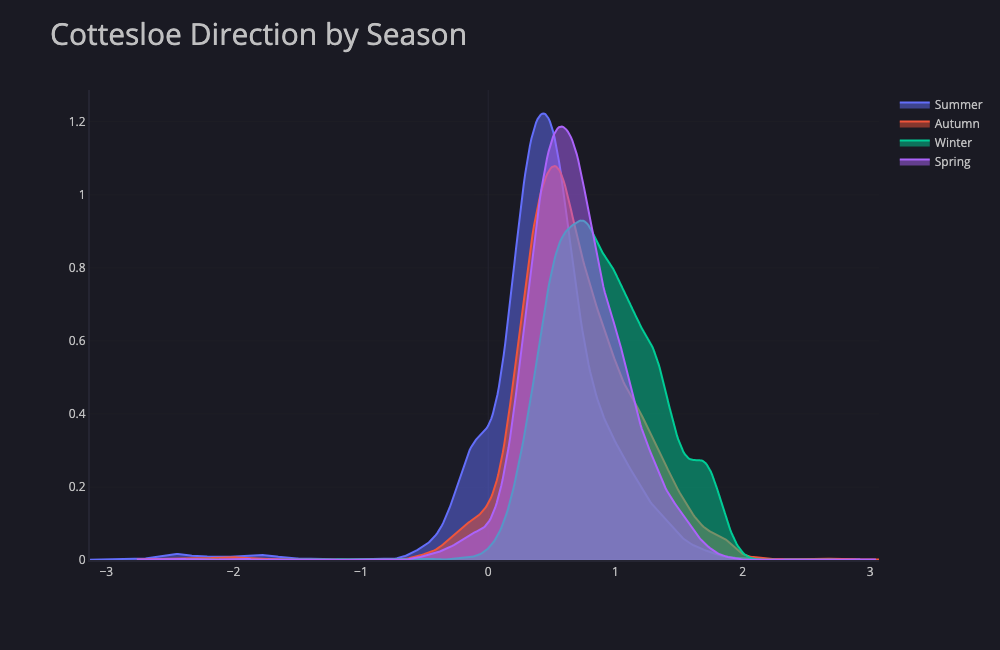

In [27]:
show(theme(p10))

# Unit Circle Representation

In [31]:
df['sinRottRad'] = np.sin(df['RottRad'])
df['cosRottRad'] = np.cos(df['RottRad'])
df['sinCottRad'] = np.sin(df['CottRad'])
df['cosCottRad'] = np.cos(df['CottRad'])

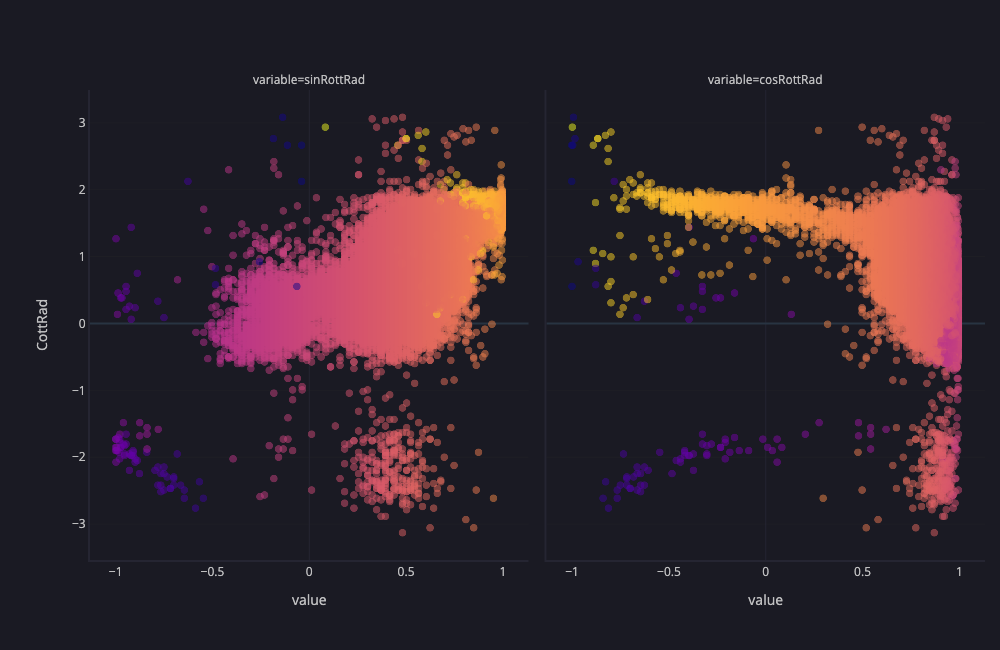

In [34]:
p_cs = px.scatter(df, ['sinRottRad','cosRottRad'], 'CottRad', color='RottRad', facet_col='variable', opacity=0.5)
show(theme(p_cs).update_layout(coloraxis_showscale=False))

___
# Assessing circular statistics

In [37]:
import astropy
import astropy.stats.circstats as circstats

In [38]:
df.rename(columns={'RottRad': 'RottRadRot', 'CottRad': 'CottRadRot'}, inplace=True)

In [39]:
# 'unrotating' radians
df['CottRad'] = (df['CottDirection'] * np.pi / 180) - np.pi
df['RottRad'] = (df['RottDirection'] * np.pi / 180) - np.pi

In [41]:
# circular-circular correlation coefficient
circstats.circcorrcoef(df['CottRad'], df['RottRad'])

0.48893680456103633

In [42]:
def linear_circ_corr(lin, circ):
    rxc = lin.corr(np.cos(circ))
    rxs = lin.corr(np.sin(circ))
    rcs = np.cos(circ).corr(np.sin(circ))
    return (rxc**2 + rxs**2 - 2*rxc*rxs*rcs) / (1 - rcs**2)

In [43]:
def circ_day(date):
    return date.dayofyear * (2*np.pi / 12)

def circ_month(date):
    return date.month * (2*np.pi / 12)

In [44]:
df['circDay'] = df['DateTime'].apply(circ_day)
df['circMonth'] = df['DateTime'].apply(circ_month)

In [45]:
# circular-circular correlation coefficient
circstats.circcorrcoef(df['CottRad'], df['circDay'])

0.01482956373802576

In [67]:
circstats.circcorrcoef(df['CottRad'], df['circMonth'])

0.38159311756146896

In [47]:
linear_circ_corr(df['CottRad'], df['Month'])

0.01779328573266128

In [48]:
linear_circ_corr(df['RottHeight'], df['CottRad'])

0.020259070230885957

In [49]:
linear_circ_corr(df['CottHeight'], df['CottRad'])

0.0265578002115219

In [50]:
linear_circ_corr(df['RottPeakPeriod'], df['CottRad'])

0.08163902542716611

In [51]:
linear_circ_corr(df['Month'], df['CottRad'])

0.022003349976481158

In [52]:
df['sinMonth'] = np.sin(df['circMonth'])
df['cosMonth'] = np.cos(df['circMonth'])

In [59]:
import sklearn
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [54]:
seed = 15
lm = LinearRegression()
sgd = SGDRegressor(loss='huber', early_stopping=True, random_state=seed)

In [55]:
def z_scale(col):
    x_bar = np.mean(col)
    x_std = np.std(col)
    return (col - x_bar) / x_std

In [56]:
df['zRottHeight'] = z_scale(df['RottHeight'])
df['zRottPP'] = z_scale(df['RottPeakPeriod'])

In [57]:
X = df[['sinMonth','cosMonth','sinRottRad','cosRottRad','zRottHeight','zRottPP']]
sin_y = df['sinCottRad']
cos_y = df['sinCottRad']

In [60]:
X_train, X_test, sin_y_train, sin_y_test = train_test_split(X, sin_y, test_size=0.2, random_state=seed)

In [61]:
sgd.fit(X_train, sin_y_train)

SGDRegressor(early_stopping=True, loss='huber', random_state=15)

In [62]:
sin_pred_train = sgd.predict(X_train)
sin_pred_test = sgd.predict(X_test)

In [63]:
r2_score(sin_y_train, sin_pred_train)

0.2534754944282225

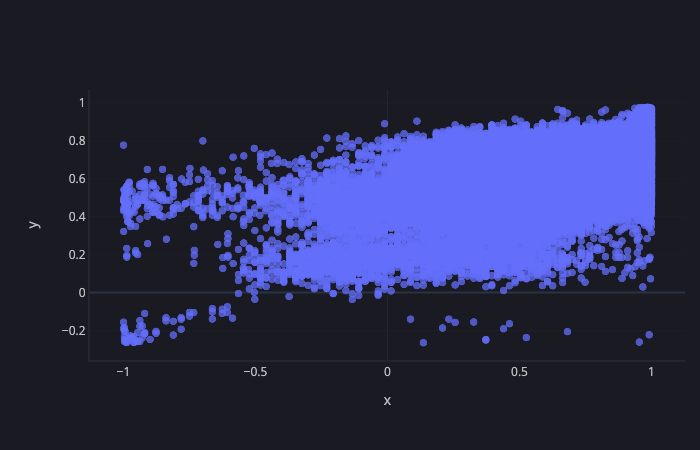

In [64]:
p_tr = px.scatter(x=sin_y_train, y=sin_pred_train, opacity=0.75)
theme(p_tr)

In [68]:
r2_score(sin_y_test, sin_pred_test)

0.2367628468260583

___
# Modelling

In [256]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor

seed = 15

In [257]:
def mape(y_true, y_pred):
    return np.mean(abs(y_pred - y_true) / y_true)

In [258]:
X = df[['RottRad','RottHeight','Month']]
y = df['CottRad']

In [259]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

In [306]:
rf = RandomForestRegressor(n_estimators=200, max_depth=10, max_features=3, n_jobs=-1, random_state=seed, verbose=1)

In [307]:
rf.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    6.6s finished


RandomForestRegressor(max_depth=10, max_features=3, n_estimators=200, n_jobs=-1,
                      random_state=15, verbose=1)

In [308]:
pred_train = rf.predict(X_train)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.6s finished


In [309]:
pred_test = rf.predict(X_test)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.1s finished


In [310]:
mape(y_train, pred_train)

0.32984190671117075

In [311]:
r2_score(y_train, pred_train)

0.3697006636675919

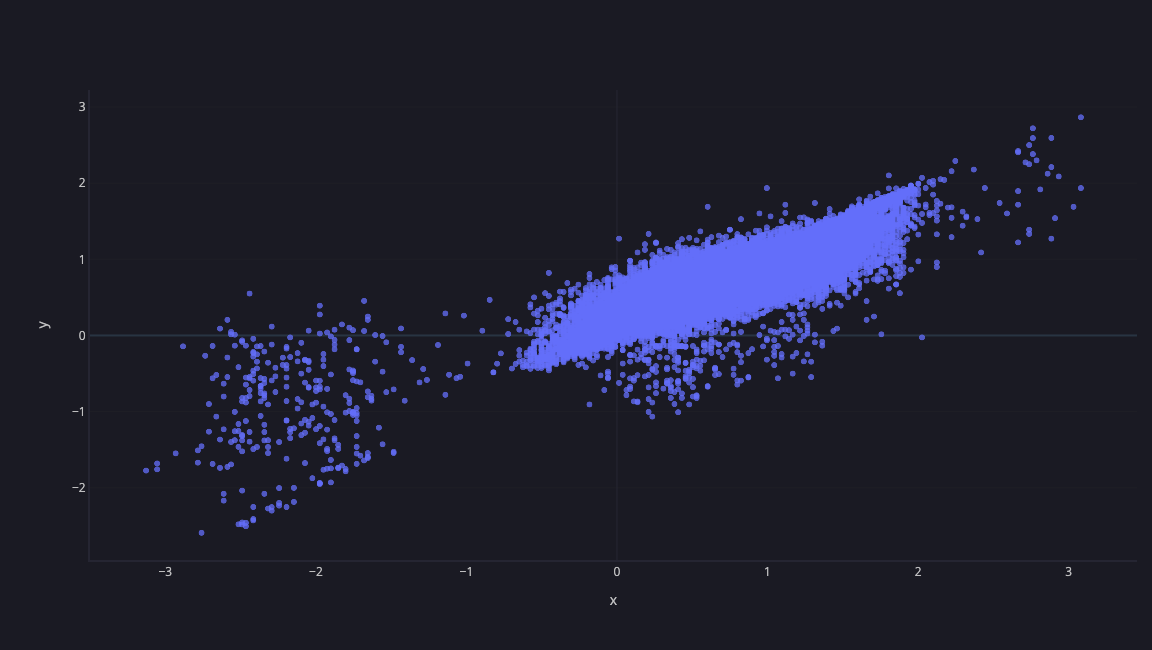

In [290]:
p_tr = px.scatter(x=y_train, y=pred_train, opacity=0.75)
theme(p_tr.update_layout(coloraxis_showscale=False))

In [312]:
mape(y_test, pred_test)

0.3524438069931996

In [313]:
r2_score(y_test, pred_test)

0.2761805375825961

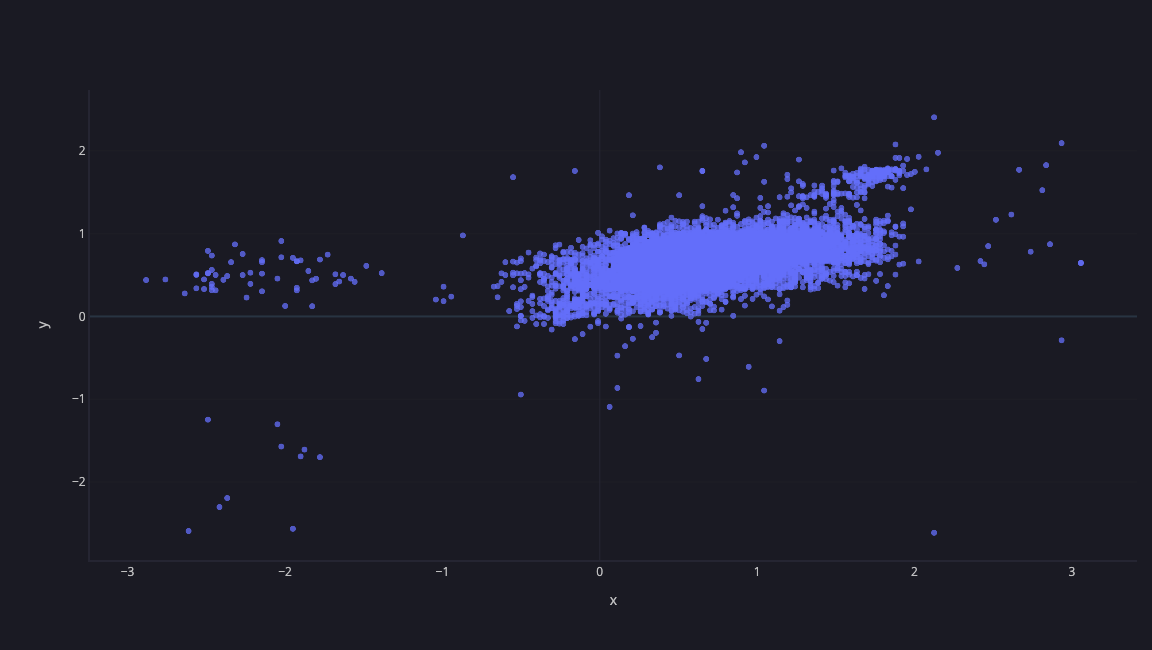

In [314]:
p_ts = px.scatter(x=y_test, y=pred_test, opacity=0.75)
theme(p_ts.update_layout(coloraxis_showscale=False))